# Import

In [2]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pathlib import Path
from dataset import ObservationStateDataset
from time import time
import matplotlib.pyplot as plt

# Bench

In [3]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

# Plot

In [4]:
def plot(kmeans):
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the digits dataset (PCA-reduced data)\n"
        "Centroids are marked with white cross"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

# FO

## Global settings

In [4]:
path = Path("./dataset/training_data_observation_state.json")
n_state = 18
n_feature = 16
data = ObservationStateDataset(path,n_state)
data, labels = data.to_x_y()

## Eval

In [5]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans_random = KMeans(init="random", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)


print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	4.338s	34051	0.336	0.300	0.317	0.176	0.312	-0.188
random   	4.413s	34061	0.349	0.306	0.326	0.171	0.321	-0.206
__________________________________________________________________________________


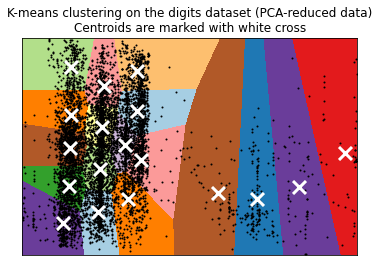

In [6]:
plot(kmeans)

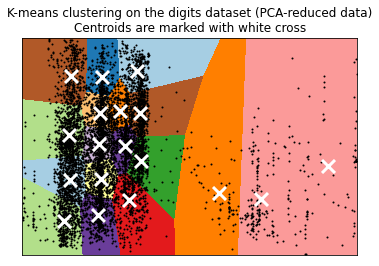

In [7]:
plot(kmeans_random)

# MO

## Global settings

In [8]:
path = Path("./dataset/training_data_observation_state_no_tree.json")
n_feature = 6
n_state = 18
data = ObservationStateDataset(path,n_state)
data, labels = data.to_x_y()

In [9]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans_random = KMeans(init="random", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)


print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	3.693s	9105	0.482	0.425	0.451	0.262	0.447	-0.111
random   	3.745s	9095	0.482	0.427	0.453	0.259	0.449	-0.088
__________________________________________________________________________________


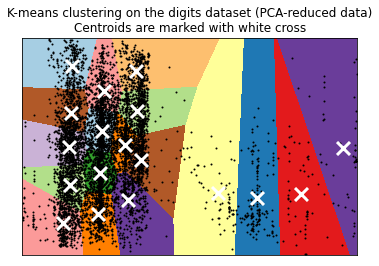

In [10]:
plot(kmeans)

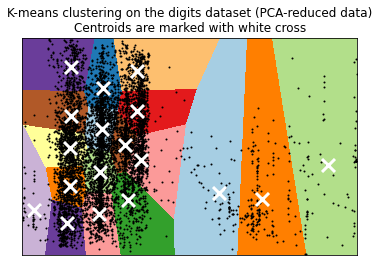

In [11]:
plot(kmeans_random)

# SMO

## Global settings

In [5]:
path = Path("./dataset/training_data_observation_state_simple_machine.json")
n_feature = 4
n_state = 18
data = ObservationStateDataset(path,n_state)
data, labels = data.to_x_y()

In [6]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans_random = KMeans(init="random", n_clusters=n_state, n_init=100, max_iter=10000)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)


print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	3.384s	3820	0.349	0.310	0.328	0.169	0.323	0.075
random   	3.353s	3821	0.347	0.308	0.326	0.166	0.321	0.025
__________________________________________________________________________________


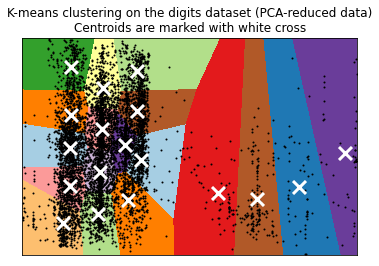

In [7]:
plot(kmeans)

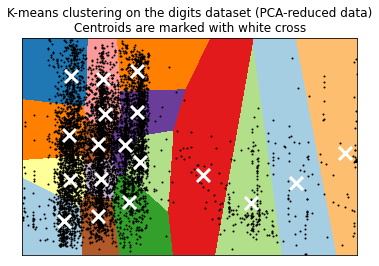

In [8]:
plot(kmeans_random)